# Fundamental Factor Long Short
## Use three factors to rank stocks: value (book to price), quality (operation margin), momentum (monthly return)

High book value per share rank high
High operation margin rank high
High monthy return rank high

Rank each criteria 
use weights 40% value 40% quality 20% momentum

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
pd.set_option('display.max_colwidth', None)
from decimal import ROUND_HALF_UP, Decimal
from statsmodels.api import OLS
import random
import statsmodels.api as sm


In [2]:
train_stock_prices = pd.read_csv('ds/train_files/stock_prices.csv')
supplemental_stock_prices = pd.read_csv('ds/supplemental_files/stock_prices.csv')
data_stock_prices = pd.concat([train_stock_prices,supplemental_stock_prices],ignore_index=True)

In [147]:
train_financials = pd.read_csv('ds/train_files/financials.csv',low_memory=False)
supplemental_financials = pd.read_csv('ds/supplemental_files/financials.csv')
train_financials["Date"] = pd.to_datetime(train_financials["Date"])
supplemental_financials["Date"] = pd.to_datetime(supplemental_financials["Date"])
data_supplemental_financials = pd.concat([train_financials,supplemental_financials],ignore_index=True)

In [129]:
train_financials.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92956 entries, 0 to 92955
Data columns (total 45 columns):
 #   Column                                                                        Non-Null Count  Dtype         
---  ------                                                                        --------------  -----         
 0   DisclosureNumber                                                              92954 non-null  float64       
 1   DateCode                                                                      92954 non-null  object        
 2   Date                                                                          92956 non-null  datetime64[ns]
 3   SecuritiesCode                                                                92954 non-null  float64       
 4   DisclosedDate                                                                 92954 non-null  object        
 5   DisclosedTime                                                                 92954 non-

In [130]:
train_financials['TypeOfDocument'].value_counts()

ForecastRevision                                     16995
FYFinancialStatements_Consolidated_JP                14780
3QFinancialStatements_Consolidated_JP                14728
1QFinancialStatements_Consolidated_JP                14718
2QFinancialStatements_Consolidated_JP                14624
NumericalCorrection                                   2551
FYFinancialStatements_NonConsolidated_JP              2458
3QFinancialStatements_NonConsolidated_JP              2411
1QFinancialStatements_NonConsolidated_JP              2405
2QFinancialStatements_NonConsolidated_JP              2366
2QFinancialStatements_Consolidated_IFRS                962
1QFinancialStatements_Consolidated_IFRS                960
FYFinancialStatements_Consolidated_IFRS                897
3QFinancialStatements_Consolidated_IFRS                881
FYFinancialStatements_REIT                             571
ForecastRevision_REIT                                  320
FYFinancialStatements_Consolidated_US                   

In [5]:
train_financials["BookValuePerShare"] = pd.to_numeric(train_financials["BookValuePerShare"],errors='coerce')
train_financials["OperatingProfit"] = pd.to_numeric(train_financials["OperatingProfit"],errors='coerce')
train_financials["NetSales"] = pd.to_numeric(train_financials["NetSales"],errors='coerce')


In [6]:
def calc_adjusted_close(df):
    df = df.sort_values("Date",ascending=False)
    df.loc[:,"cummulative_adjustment_factor"] = df["AdjustmentFactor"].cumprod()
    df.loc[:,"adjusted_close"] = (df["cummulative_adjustment_factor"]*df["Close"]).map(lambda x: float(Decimal(str(x)).quantize(Decimal("0.1"),rounding=ROUND_HALF_UP)))
    df = df.sort_values("Date")
    df.loc[df["adjusted_close"]==0,"adjusted_close"] = np.nan
    df.loc[:,"adjusted_close"] = df.loc[:,"adjusted_close"].ffill()
    return df

In [7]:
def calc_spread_return_sharpe(df: pd.DataFrame, portfolio_size: int = 200, toprank_weight_ratio: float = 2) -> float:
    """
    Args:
        df (pd.DataFrame): predicted results
        portfolio_size (int): # of equities to buy/sell
        toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
    Returns:
        (float): sharpe ratio
    """
    def _calc_spread_return_per_day(df, portfolio_size, toprank_weight_ratio):
        """
        Args:
            df (pd.DataFrame): predicted results
            portfolio_size (int): # of equities to buy/sell
            toprank_weight_ratio (float): the relative weight of the most highly ranked stock compared to the least.
        Returns:
            (float): spread return
        """
        assert df['Rank'].min() == 0
        assert df['Rank'].max() == len(df['Rank']) - 1
        weights = np.linspace(start=toprank_weight_ratio, stop=1, num=portfolio_size)
        #Target is the rate of change 
        purchase = (df.sort_values(by='Rank')['Target'][:portfolio_size] * weights).sum() / weights.mean()
        short = (df.sort_values(by='Rank', ascending=False)['Target'][:portfolio_size] * weights).sum() / weights.mean()
        return purchase - short

    buf = df.groupby('Date').apply(_calc_spread_return_per_day, portfolio_size, toprank_weight_ratio)
    buf.plot()
    sharpe_ratio = buf.mean() / buf.std()
    return sharpe_ratio

In [190]:
def create_features(df,fin):
    df = df.copy()
    df["Date"] = pd.to_datetime(df["Date"])
    df = df.drop(["RowId"],axis=1)
    df = df[df["Date"]!="2020-10-01"]
    df = df.groupby("SecuritiesCode").apply(calc_adjusted_close).reset_index(drop=True).sort_values(["Date","SecuritiesCode"]).reset_index(drop=True)
    fin = fin.copy()
    fin = fin[(fin["TypeOfDocument"].isin(["1QFinancialStatements_Consolidated_JP","2QFinancialStatements_Consolidated_JP","3QFinancialStatements_Consolidated_JP","FYFinancialStatements_Consolidated_JP","1QFinancialStatements_NonConsolidated_JP","2QFinancialStatements_NonConsolidated_JP","3QFinancialStatements_NonConsolidated_JP","FYFinancialStatements_NonConsolidated_JP","1QFinancialStatements_Consolidated_IFRS","2QFinancialStatements_Consolidated_IFRS","3QFinancialStatements_Consolidated_IFRS","FYFinancialStatements_Consolidated_IFRS","1QFinancialStatements_NonConsolidated_IFRS","2QFinancialStatements_NonConsolidated_IFRS","3QFinancialStatements_NonConsolidated_IFRS","FYFinancialStatements_NonConsolidated_IFRS","1QFinancialStatements_Consolidated_US","2QFinancialStatements_Consolidated_US","3QFinancialStatements_Consolidated_US","FYFinancialStatements_Consolidated_US","1QFinancialStatements_NonConsolidated_US","2QFinancialStatements_NonConsolidated_US","3QFinancialStatements_NonConsolidated_US","FYFinancialStatements_NonConsolidated_US"]))] 
    fin["BookValuePerShare"] = pd.to_numeric(fin["BookValuePerShare"],errors='coerce')
    fin["EarningsPerShare"] = pd.to_numeric(fin["EarningsPerShare"],errors='coerce')
    fin["ForecastEarningsPerShare"] = pd.to_numeric(fin["ForecastEarningsPerShare"],errors='coerce')
    fin["OperatingProfit"]= pd.to_numeric(fin["OperatingProfit"],errors='coerce')
    fin["NetSales"] = pd.to_numeric(fin["NetSales"],errors='coerce')
    fin["TotalAssets"]= pd.to_numeric(fin["TotalAssets"],errors='coerce')
    fin["Profit"]= pd.to_numeric(fin["Profit"],errors='coerce')
    df = df.join(fin[["Date","SecuritiesCode","BookValuePerShare","EarningsPerShare","ForecastEarningsPerShare","OperatingProfit","NetSales","Profit","TotalAssets"]].set_index(["Date","SecuritiesCode"]),on=["Date","SecuritiesCode"])
    df["EarningsAnnouncement"] = df["EarningsPerShare"].notna()
    df["ThreeDayReturnsOverEarningsAnnouncement"] = df.groupby(["SecuritiesCode"])["adjusted_close"].apply(lambda x: (x.shift(-1)-x.shift(2))/x.shift(2))
    df["BookValuePerShare"] = df.groupby(["SecuritiesCode"])["BookValuePerShare"].ffill()
    df["EarningsPerShare"] = df.groupby(["SecuritiesCode"])["EarningsPerShare"].ffill()
    df["ForecastEarningsPerShare"] = df.groupby(["SecuritiesCode"])["ForecastEarningsPerShare"].ffill()
    df["book_to_price"] = df["BookValuePerShare"]/df["Close"]
    df["earnings_to_price"] = df["EarningsPerShare"]/df["Close"]
    df["NetSales"] = df.groupby(["SecuritiesCode"])["NetSales"].ffill()
    df["OperatingProfit"] = df.groupby(["SecuritiesCode"])["OperatingProfit"].ffill()
    df["OperatingMargin"] = df["OperatingProfit"]/df["NetSales"]
    df["TotalAssets"] = df.groupby(["SecuritiesCode"])["TotalAssets"].ffill()
    df["Profit"] = df.groupby(["SecuritiesCode"])["Profit"].ffill()
    df["TotalProfitOverAssets"] = df["Profit"]/df["TotalAssets"]
    df["MonthlyReturn"] = df.groupby("SecuritiesCode")["adjusted_close"].pct_change(30)
    df["YearlyReturn"] = df.groupby("SecuritiesCode")["adjusted_close"].pct_change(365)
    df=df.dropna(subset=["book_to_price","OperatingMargin","MonthlyReturn"])
    df["RankValue"]=df.groupby('Date')["book_to_price"].rank(method='first',ascending=False)
    df["RankQuality"]=df.groupby('Date')["OperatingMargin"].rank(method='first',ascending=False)
    df["RankMomentum"]=df.groupby('Date')["MonthlyReturn"].rank(method='first',ascending=False)
    df["Score"] = (0.4*df["RankValue"]) + (0.4*df["RankQuality"]) + (0.2*df["RankMomentum"])
    df["Rank"] = df.groupby(["Date"])["Score"].rank(method="first")-1
    return df

In [191]:
test = create_features(train_stock_prices,train_financials)

In [192]:
test[(test["SecuritiesCode"]==1376)&(test["EarningsAnnouncement"]==True)][["Date","EarningsPerShare","EarningsAnnouncement","ThreeDayReturnsOverEarningsAnnouncement"]]

,Date,EarningsPerShare,EarningsAnnouncement,ThreeDayReturnsOverEarningsAnnouncement
119505,2017-04-06,45.42,True,-0.029350
241510,2017-07-11,126.86,True,0.018634
348592,2017-10-03,19.87,True,0.043115
465621,2018-01-05,16.51,True,0.029965
581328,2018-04-05,31.05,True,0.014203
710839,2018-07-13,83.35,True,0.042210
814150,2018-10-02,20.14,True,0.016774
933327,2019-01-07,22.06,True,0.011078
1049249,2019-04-04,33.90,True,0.002092
1175316,2019-07-12,109.39,True,-0.009909


In [186]:
test[(test["SecuritiesCode"]==1376)&(test["Date"]>="2020-10-02")]['adjusted_close']

1755044    1580.0
1757033    1615.0
1759023    1588.0
1761013    1541.0
1763003    1502.0
            ...  
2320547    1381.0
2322547    1348.0
2324547    1353.0
2326547    1327.0
2328547    1332.0
Name: adjusted_close, Length: 288, dtype: float64

In [142]:
train_financials[(train_financials["SecuritiesCode"]==4765 )& (train_financials["Date"]=="2017-03-10")][["Date","SecuritiesCode","BookValuePerShare","EarningsPerShare","ForecastEarningsPerShare","OperatingProfit","NetSales"]]

,Date,SecuritiesCode,BookValuePerShare,EarningsPerShare,ForecastEarningsPerShare,OperatingProfit,NetSales
4198,2017-03-10,4765.0,NaN,NaN,NaN,NaN,NaN
4199,2017-03-10,4765.0,NaN,NaN,－,NaN,NaN


In [145]:
train_financials[(train_financials["SecuritiesCode"]==3900 )& (train_financials["Date"]=="2021-11-15")][["Date","SecuritiesCode","BookValuePerShare","EarningsPerShare","ForecastEarningsPerShare","OperatingProfit","NetSales"]]

,Date,SecuritiesCode,BookValuePerShare,EarningsPerShare,ForecastEarningsPerShare,OperatingProfit,NetSales
92764,2021-11-15,3900.0,247.53,40.84,－,575000000.0,7.769000e+09
92765,2021-11-15,3900.0,NaN,NaN,－,NaN,NaN


In [57]:
train_financials[(~train_financials["BookValuePerShare"].isna()) &( train_financials["SecuritiesCode"]==7453)][["Date","BookValuePerShare"]]

,Date,BookValuePerShare
9,2017-01-05,5350.88
4851,2017-04-12,5791.78
9496,2017-07-05,5721.39
13774,2017-10-04,5982.20
18681,2018-01-10,6260.19
23372,2018-04-11,6476.77
27896,2018-07-04,6724.63
32113,2018-10-03,7000.33
36790,2019-01-09,7220.74
41461,2019-04-10,7258.30


In [112]:
test[(test["SecuritiesCode"]==7453) & (test["Date"]=="2019-07-10")]["Close"]

1172750    20020.0
Name: Close, dtype: float64

In [113]:
test[(test["SecuritiesCode"]==7453) & (test["Date"]=="2019-10-10")]["Close"]

1293424    1990.0
Name: Close, dtype: float64

In [72]:
test[test["Date"]=='2019-07-10']

,Date,SecuritiesCode,Open,High,Low,Close,Volume,AdjustmentFactor,ExpectedDividend,SupervisionFlag,...,OperatingProfit,NetSales,book_to_price,OperatingMargin,MonthlyReturn,RankValue,RankQuality,RankMomentum,Score,Rank
1171427,2019-07-10,1301,3030.0,3045.0,3030.0,3035.0,15200,1.0,NaN,False,...,3.831000e+09,2.561510e+11,0.969114,0.014956,0.101633,865.0,1666.0,299.0,1072.2,1344.0
1171428,2019-07-10,1332,683.0,700.0,681.0,698.0,1839400,1.0,NaN,False,...,2.168500e+10,7.121110e+11,0.673754,0.030452,0.073846,1177.0,1484.0,469.0,1158.2,1509.0
1171429,2019-07-10,1333,3260.0,3300.0,3245.0,3285.0,197700,1.0,NaN,False,...,2.175800e+10,9.224680e+11,0.725102,0.023587,-0.039474,1130.0,1576.0,1613.0,1405.0,1756.0
1171430,2019-07-10,1376,1400.0,1400.0,1306.0,1312.0,56700,1.0,NaN,False,...,5.180000e+08,3.624100e+10,1.221936,0.014293,-0.006813,604.0,1675.0,1311.0,1173.8,1531.0
1171431,2019-07-10,1377,3200.0,3215.0,3130.0,3190.0,202300,1.0,NaN,False,...,7.717000e+09,6.274600e+10,0.707837,0.122988,-0.056213,1141.0,400.0,1687.0,953.8,1057.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173365,2019-07-10,9990,994.0,995.0,972.0,977.0,122700,1.0,NaN,False,...,3.723000e+09,5.577400e+10,1.006571,0.066752,-0.033630,825.0,922.0,1572.0,1013.2,1201.0
1173366,2019-07-10,9991,979.0,981.0,966.0,977.0,26000,1.0,NaN,False,...,6.009000e+09,1.083780e+11,1.493060,0.055445,0.029505,401.0,1099.0,878.0,775.6,556.0
1173367,2019-07-10,9993,1665.0,1666.0,1648.0,1648.0,5700,1.0,NaN,False,...,1.540000e+08,2.694500e+10,1.595400,0.005715,0.017912,345.0,1746.0,1025.0,1041.4,1264.0
1173368,2019-07-10,9994,2233.0,2247.0,2225.0,2229.0,8700,1.0,NaN,False,...,6.894000e+09,1.677500e+11,1.337492,0.041097,0.108404,503.0,1336.0,275.0,790.6,591.0


In [19]:
test = create_features(data_stock_prices,data_supplemental_financials)
test=test[test["Date"]>"2018"]

0.014041268161164378

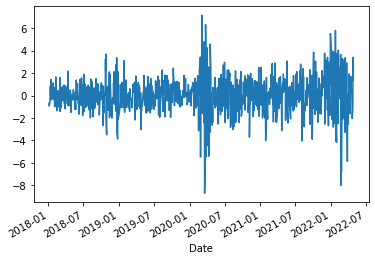

In [20]:
calc_spread_return_sharpe(test)

-0.01497679306120754

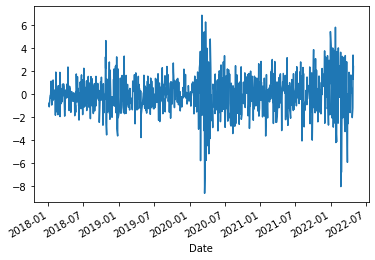

In [17]:
calc_spread_return_sharpe(test)

-0.04468006768747024

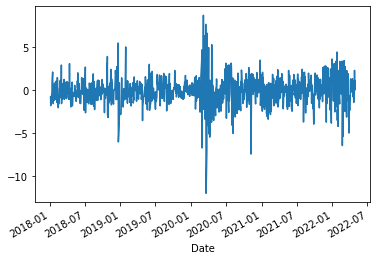

In [12]:
calc_spread_return_sharpe(test)

In [ ]:
test["Score"] = (0.4*test["RankValue"]) + (0.4*test["RankQuality"]) + (0.2*test["RankMomentum"])
test

In [ ]:
calc_spread_return_sharpe(test[test["Date"]>="2021-01-04"])